# Reinforcement Learning Project – Lunar Lander (Continuous Environment)

## Environment Overview

This notebook tackles the **LunarLanderContinuous-v2** environment, where the agent must learn to land a lunar module smoothly on a designated landing pad using continuous control. The complexity of this task comes from its continuous state and action spaces, requiring algorithms capable of function approximation and gradient-based learning.

### Environment Characteristics:
- **Observation space**: Continuous 8-dimensional vector  
  (position, velocity, angle, angular velocity, and leg contact flags)
- **Action space**: Continuous 2-dimensional vector  
  (main engine and side engine thrusts in the range [-1, 1])

## Algorithms Implemented

We implement and compare two algorithms for continuous action environments:
1. **DQN** –  
2. **Sarsa** –



<div style="text-align: center;">
    <strong style="display: block; margin-bottom: 10px;">Group ??</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Joana Rodrigues</td>
            <td style="border: 1px solid white; padding: 8px;">20240603</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Mara Simões</td>
            <td style="border: 1px solid white; padding: 8px;">20240326</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Matilde Street</td>
            <td style="border: 1px solid white; padding: 8px;">20240523</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Tomás Luzia</td>
            <td style="border: 1px solid white; padding: 8px;">20230477</td>
        </tr>
    </table>
</div>

### 🔗 Table of Contents <a id='table-of-contents'></a>
1. [Imports](#imports)
---

# 1. Imports

**Import Libraries**

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

import gymnasium as gym

# Importing necessary libraries for DQN implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
import torch.optim as optim
import plotly.graph_objects as go
import plotly.express as px
import itertools


# Zip and download grid results
from google.colab import files
import zipfile

# Visualize the lander
!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
import imageio
import base64
from IPython.display import HTML
import torch
import gymnasium as gym
import tempfile

In [3]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379367 sha256=f37d6027259c4a0fe5c5bdc70d2dffb5a5272321e4293aeca4fcc4e50c0c653b
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [4]:
# Set a fixed seed
SEED = 42

# Python / NumPy / PyTorch seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Force deterministic behavior in PyTorch (optional, may slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


**Load Environment**

In [5]:
# Create Gym environment with seed
env = gym.make("LunarLander-v3")
env.reset(seed=SEED)  # Seed environment state
env.action_space.seed(SEED)  # Seed action space (e.g., ε-greedy sampling)
env.observation_space.seed(SEED)  # Seed observation space (e.g., initial noise)

# Observe the state and action spaces
print("Observation space:", env.observation_space)
print("Example of a state:", env.reset()[0])  # [0] because reset() returns (observation, info)

print("Action space:", env.action_space)
print("Number of possible actions:", env.action_space.n)

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Example of a state: [-0.0055192   1.41475    -0.55905515  0.17020425  0.00640219  0.12663427
  0.          0.        ]
Action space: Discrete(4)
Number of possible actions: 4


# 2. DQN

## 2.1. Neural Network

We define a fully connected neural network to approximate the Q-function.
The input is the 8-dimensional state from the environment, and the output is a vector of 4 Q-values, one for each possible action.
This network will be used to predict the value of each action given a state.

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # Fully connected layers
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.out(x)
        return q_values

In [ ]:
# Instantiate the model
state_dim = env.observation_space.shape[0]  # should be 8
action_dim = env.action_space.n             # should be 4
q_net = QNetwork(state_dim, action_dim)

## 2.2. Replay Buffer

We implement a replay buffer to store past transitions (state, action, reward, next_state, done).
During training, the agent samples random mini-batches from this buffer to break temporal correlations and stabilize learning.
This mechanism is essential for Deep Q-Learning to resemble supervised learning.

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """Store a transition in the buffer."""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Sample a random batch of transitions."""
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        # Convert to tensors
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [ ]:
buffer = ReplayBuffer(capacity=10000)

## 2.3. Epsilon-greedy

We implement an epsilon-greedy action selection strategy to balance exploration and exploitation:
- With probability ε, the agent selects a random action (exploration).
- With probability 1−ε, it selects the action with the highest predicted Q-value (exploitation).

This allows the agent to discover new strategies while gradually learning to exploit the best ones.

In [ ]:
def select_action(state, q_network, epsilon, action_dim):
    """Selects an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        # Explore: random action
        return np.random.randint(action_dim)
    else:
        # Exploit: choose best action based on Q-values
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # shape (1, 8)
        q_values = q_network(state_tensor)
        return torch.argmax(q_values).item()

In [ ]:
state, _ = env.reset()
epsilon = 0.3

action = select_action(state, q_net, epsilon, action_dim)
print("Selected action:", action)

Selected action: 3


## 2.4. Target Network

We create a separate target network to provide stable Q-value targets during training.
Initially, the target network is a copy of the main Q-network
Throughout training, it is updated periodically to reflect the weights of the current Q-network.
This technique reduces oscillations and helps stabilize the learning process.

In [ ]:
# Create the target Q-network
target_q_net = QNetwork(state_dim, action_dim)
target_q_net.load_state_dict(q_net.state_dict())  # Copy weights from q_net
target_q_net.eval()  # Set to evaluation mode (no dropout, no batchnorm)

QNetwork(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
)

## 2.5. Training

We implement the main training loop where the agent interacts with the environment and stores transitions in the replay buffer.
Mini-batches are sampled to update the Q-network using target Q-values computed from a separate target network.
The network is trained by minimizing the mean squared error between the predicted Q-values and the target Q-values, and the target network is periodically updated to stabilize training.
Throughout training, we log the total reward per episode and track the value of epsilon to monitor the exploration-exploitation trade-off.
At the end, both reward and epsilon histories are saved to text files for visualization and analysis.

In [ ]:
# Hyperparameters
num_episodes = 500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
target_update_freq = 1000  # steps
learning_rate = 1e-3

# Optimizer
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

# Track total steps
total_steps = 0

# For logging
episode_rewards = []
epsilon_history = []

for episode in range(num_episodes):
    # Pass fixed seed again to env.reset for reproducibility
    state, _ = env.reset(seed=SEED + episode)  # optionally vary seed per episode
    total_reward = 0
    done = False

    while not done:
        # Select action using epsilon-greedy
        action = select_action(state, q_net, epsilon, action_dim)

        # Interact with environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store transition in replay buffer
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        total_steps += 1

        # Start training only after batch is ready
        if len(buffer) >= batch_size:
            # Sample mini-batch
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            # Compute Q-values for current states
            q_values = q_net(states).gather(1, actions)

            # Compute max Q-values for next states from target network
            with torch.no_grad():
                max_next_q = target_q_net(next_states).max(1)[0].unsqueeze(1)
                q_targets = rewards + gamma * max_next_q * (1 - dones)

            # Compute loss
            loss = torch.nn.functional.mse_loss(q_values, q_targets)

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Periodically update target network
        if total_steps % target_update_freq == 0:
            target_q_net.load_state_dict(q_net.state_dict())

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Log metrics
    episode_rewards.append(total_reward)
    epsilon_history.append(epsilon)
    print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

# Save episode rewards to a file
with open("episode_rewards.txt", "w") as f:
    for r in episode_rewards:
        f.write(f"{r}\n")

# Save epsilon history to a file
with open("epsilon_history.txt", "w") as f:
    for eps in epsilon_history:
        f.write(f"{eps}\n")

Episode 0, Reward: -422.62, Epsilon: 0.995
Episode 1, Reward: -95.67, Epsilon: 0.990
Episode 2, Reward: -373.23, Epsilon: 0.985
Episode 3, Reward: -206.34, Epsilon: 0.980
Episode 4, Reward: -53.25, Epsilon: 0.975
Episode 5, Reward: -135.65, Epsilon: 0.970
Episode 6, Reward: -78.20, Epsilon: 0.966
Episode 7, Reward: -359.07, Epsilon: 0.961
Episode 8, Reward: -81.63, Epsilon: 0.956
Episode 9, Reward: -178.44, Epsilon: 0.951
Episode 10, Reward: -261.60, Epsilon: 0.946
Episode 11, Reward: -73.91, Epsilon: 0.942
Episode 12, Reward: -103.93, Epsilon: 0.937
Episode 13, Reward: -125.49, Epsilon: 0.932
Episode 14, Reward: -163.68, Epsilon: 0.928
Episode 15, Reward: -300.71, Epsilon: 0.923
Episode 16, Reward: -93.77, Epsilon: 0.918
Episode 17, Reward: -122.77, Epsilon: 0.914
Episode 18, Reward: -127.45, Epsilon: 0.909
Episode 19, Reward: -122.99, Epsilon: 0.905
Episode 20, Reward: -3.99, Epsilon: 0.900
Episode 21, Reward: -117.04, Epsilon: 0.896
Episode 22, Reward: -71.18, Epsilon: 0.891
Episode

## 2.6. Visualization

In [ ]:
# Load episode rewards
with open("episode_rewards.txt", "r") as f:
    episode_rewards = [float(line.strip()) for line in f.readlines()]

# Load epsilon history
with open("epsilon_history.txt", "r") as f:
    epsilon_history = [float(line.strip()) for line in f.readlines()]

# Create episode index
episodes = np.arange(len(episode_rewards))

# Compute moving average of rewards
window = 20
moving_avg = pd.Series(episode_rewards).rolling(window).mean()

In [ ]:
# Plot 1: Reward per episode + moving average
fig = go.Figure()

# Linha de rewards
fig.add_trace(go.Scatter(
    x=episodes,
    y=episode_rewards,
    mode='lines',
    name='Reward per Episode',
    line=dict(color='lightblue'),
    hoverinfo='x+y'
))

# Linha de média móvel
fig.add_trace(go.Scatter(
    x=episodes,
    y=moving_avg,
    mode='lines',
    name=f'{window}-Episode Moving Average',
    line=dict(color='red', width=3),
    hoverinfo='x+y'
))

# Layout
fig.update_layout(
    title="DQN Training Performance on LunarLander-v3",
    xaxis_title="Episode",
    yaxis_title="Total Reward",
    hovermode="x unified",
    template="plotly_white",
    width=1000,
    height=500
)

fig.show()

In [ ]:
# Plot 2: Epsilon decay over time
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=episodes,
    y=epsilon_history,
    mode='lines',
    name='Epsilon',
    line=dict(color='purple'),
    hoverinfo='x+y'
))

fig.update_layout(
    title="Exploration Rate (Epsilon) Over Time",
    xaxis_title="Episode",
    yaxis_title="Epsilon",
    hovermode="x unified",
    template="plotly_white",
    width=1000,
    height=400
)

fig.show()

In [ ]:
# Plot 3: Histogram of reward distribution
fig = px.histogram(
    x=episode_rewards,
    nbins=30,
    labels={'x': 'Total Reward', 'y': 'Frequency'},
    title="Reward Distribution Across Episodes",
    template="plotly_white"
)

fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.update_layout(
    width=800,
    height=500,
    xaxis_title="Total Reward",
    yaxis_title="Frequency"
)

fig.show()

## 2.7. Grid

Grid Search Motivation and Parameter Selection

Based on our training results and diagnostic plots (reward curve, epsilon decay, reward distribution), we observed that:

- The agent improves over time but shows high variance and inconsistent convergence.
- Most episodes still result in suboptimal performance (reward < 200).
- Epsilon decays rather quickly, which may reduce useful exploration too early.

To address these issues, we chose to perform a focused grid search on the following parameters:

1. learning_rate
   Controls how fast the Q-network updates. Lower values can improve stability in noisy environments.
   Tested values: 1e-3, 5e-4, 1e-4

2. epsilon_decay
   Defines how quickly the exploration rate (epsilon) decreases. Slower decay allows longer exploration and better long-term learning.
   Tested values: 0.995, 0.990, 0.985

3. target_update_freq
   Determines how often the target Q-network is updated. Updating more frequently can help reduce instability from stale targets.
   Tested values: 1000, 500, 200

This grid search will train a separate DQN agent for each combination of these parameters, and store results in separate folders for later comparison.


In [ ]:
# # Q-network
# class QNetwork(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(QNetwork, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, output_dim)
#         )

#     def forward(self, x):
#         x = torch.FloatTensor(x)
#         return self.net(x)

# # Replay Buffer
# class ReplayBuffer:
#     def __init__(self, capacity):
#         self.buffer = deque(maxlen=capacity)

#     def add(self, state, action, reward, next_state, done):
#         self.buffer.append((state, action, reward, next_state, done))

#     def sample(self, batch_size):
#         batch = random.sample(self.buffer, batch_size)
#         states, actions, rewards, next_states, dones = zip(*batch)
#         states = torch.FloatTensor(states)
#         actions = torch.LongTensor(actions).unsqueeze(1)
#         rewards = torch.FloatTensor(rewards).unsqueeze(1)
#         next_states = torch.FloatTensor(next_states)
#         dones = torch.FloatTensor(dones).unsqueeze(1)
#         return states, actions, rewards, next_states, dones

#     def __len__(self):
#         return len(self.buffer)

# # Epsilon-greedy
# def select_action(state, q_net, epsilon, action_dim):
#     if random.random() < epsilon:
#         return random.randint(0, action_dim - 1)
#     else:
#         with torch.no_grad():
#             q_values = q_net(state)
#             return torch.argmax(q_values).item()

# # Grid
# param_grid = {
#     'learning_rate': [5e-4, 1e-4],
#     'epsilon_decay': [0.990, 0.985],
#     'target_update_freq': [1000, 500, 200],
# }

# param_combinations = list(itertools.product(
#     param_grid['learning_rate'],
#     param_grid['epsilon_decay'],
#     param_grid['target_update_freq']
# ))


# for i, (lr, eps_decay, target_freq) in enumerate(param_combinations):
#     run_name = f"run_{i+1:02d}_lr{lr}_epsdecay{eps_decay}_tuf{target_freq}"
#     print(f"\n Starting {run_name}")
#     os.makedirs(run_name, exist_ok=True)

#     # environment
#     env = gym.make("LunarLander-v3")
#     env.reset(seed=SEED)
#     env.action_space.seed(SEED)
#     env.observation_space.seed(SEED)
#     input_dim = env.observation_space.shape[0]
#     action_dim = env.action_space.n

#     # networks, optimizer, buffer
#     q_net = QNetwork(input_dim, action_dim)
#     target_q_net = QNetwork(input_dim, action_dim)
#     target_q_net.load_state_dict(q_net.state_dict())
#     buffer = ReplayBuffer(capacity=100_000)
#     optimizer = optim.Adam(q_net.parameters(), lr=lr)

#     # Training Hyperparameters
#     num_episodes = 500
#     batch_size = 64
#     gamma = 0.99
#     epsilon = 1.0
#     epsilon_min = 0.01
#     total_steps = 0
#     episode_rewards = []
#     epsilon_history = []

#     for episode in range(num_episodes):
#         state, _ = env.reset(seed=SEED + episode)
#         done = False
#         total_reward = 0

#         while not done:
#             action = select_action(state, q_net, epsilon, action_dim)
#             next_state, reward, terminated, truncated, _ = env.step(action)
#             done = terminated or truncated

#             buffer.add(state, action, reward, next_state, done)
#             state = next_state
#             total_reward += reward
#             total_steps += 1

#             if len(buffer) >= batch_size:
#                 states, actions, rewards, next_states, dones = buffer.sample(batch_size)
#                 q_values = q_net(states).gather(1, actions)
#                 with torch.no_grad():
#                     max_next_q = target_q_net(next_states).max(1)[0].unsqueeze(1)
#                     q_targets = rewards + gamma * max_next_q * (1 - dones)
#                 loss = nn.functional.mse_loss(q_values, q_targets)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             if total_steps % target_freq == 0:
#                 target_q_net.load_state_dict(q_net.state_dict())

#         epsilon = max(epsilon_min, epsilon * eps_decay)
#         episode_rewards.append(total_reward)
#         epsilon_history.append(epsilon)
#         print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

#     # Save Results
#     with open(os.path.join(run_name, "episode_rewards.txt"), "w") as f:
#         for r in episode_rewards:
#             f.write(f"{r}\n")

#     with open(os.path.join(run_name, "epsilon_history.txt"), "w") as f:
#         for eps in epsilon_history:
#             f.write(f"{eps}\n")

#     with open(os.path.join(run_name, "params.txt"), "w") as f:
#         f.write(f"learning_rate = {lr}\n")
#         f.write(f"epsilon_decay = {eps_decay}\n")
#         f.write(f"target_update_freq = {target_freq}\n")


In [ ]:
# # Collect run data
# runs = []

# for folder in sorted(os.listdir(".")):
#     if folder.startswith("run_") and os.path.isdir(folder):
#         try:
#             with open(os.path.join(folder, "params.txt")) as f:
#                 params = {
#                     line.strip().split(" = ")[0]: line.strip().split(" = ")[1]
#                     for line in f if " = " in line
#                 }

#             rewards = np.loadtxt(os.path.join(folder, "episode_rewards.txt"))
#             avg_last_50 = np.mean(rewards[-50:])

#             runs.append({
#                 "folder": folder,
#                 "learning_rate": float(params["learning_rate"]),
#                 "epsilon_decay": float(params["epsilon_decay"]),
#                 "target_update_freq": int(params["target_update_freq"]),
#                 "avg_reward": avg_last_50,
#                 "rewards": rewards
#             })
#         except Exception as e:
#             print(f"Error in {folder}: {e}")

# # Sort by best performance
# runs = sorted(runs, key=lambda x: x["avg_reward"], reverse=True)

In [ ]:
# # Best run (top result)
# best = runs[0]  # sorted by avg_reward descending

# print("\nBest Run:")
# print(f"Run name: {best['folder']}")
# print(f"Learning Rate       : {best['learning_rate']}")
# print(f"Epsilon Decay       : {best['epsilon_decay']}")
# print(f"Target Update Freq  : {best['target_update_freq']}")
# print(f"Avg Reward (last 50): {best['avg_reward']:.2f}")



# # OUTPUT
# Best Run:
# Run name: run_06_lr0.0005_epsdecay0.985_tuf200
# Learning Rate       : 0.0005
# Epsilon Decay       : 0.985
# Target Update Freq  : 200
# Avg Reward (last 50): 274.12

In [ ]:
# !zip -r grid_results.zip run_*

In [ ]:
# files.download("grid_results.zip")

## 2.8. Grid Visualizations

In [ ]:
uploaded = files.upload()

# Define extraction path
extract_path = "grid_extracted"
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile("grid_results.zip", "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Zip extracted to:", extract_path)

Saving grid_results.zip to grid_results.zip
Zip extracted to: grid_extracted


In [ ]:
# Store results from all runs
runs = []

# Loop through each run folder
for folder in sorted(os.listdir(extract_path)):
    run_path = os.path.join(extract_path, folder)
    if os.path.isdir(run_path) and folder.startswith("run_"):
        try:
            # Read params.txt
            with open(os.path.join(run_path, "params.txt")) as f:
                params = {
                    line.strip().split(" = ")[0]: line.strip().split(" = ")[1]
                    for line in f if " = " in line
                }

            # Read rewards
            rewards = np.loadtxt(os.path.join(run_path, "episode_rewards.txt"))
            avg_last_50 = np.mean(rewards[-50:])  # average over last 50 episodes

            # Try to read epsilon history
            epsilon_path = os.path.join(run_path, "epsilon_history.txt")
            epsilon_history = None
            if os.path.exists(epsilon_path):
                epsilon_history = np.loadtxt(epsilon_path)

            runs.append({
                "folder": folder,
                "learning_rate": float(params["learning_rate"]),
                "epsilon_decay": float(params["epsilon_decay"]),
                "target_update_freq": int(params["target_update_freq"]),
                "avg_reward": avg_last_50,
                "rewards": rewards,
                "epsilon_history": epsilon_history
            })

        except Exception as e:
            print(f"Error loading {folder}: {e}")

In [ ]:
# Plot: reward curves (moving average)
def plot_reward_curves_plotly(runs, window=20):
    fig = go.Figure()
    for run in runs:
        rewards = run["rewards"]
        if len(rewards) >= window:
            moving_avg = np.convolve(rewards, np.ones(window) / window, mode="valid")
            label = f"lr={run['learning_rate']}, eps={run['epsilon_decay']}, tuf={run['target_update_freq']}"
            fig.add_trace(go.Scatter(y=moving_avg, mode="lines", name=label))
    fig.update_layout(
        title=f"DQN Reward Curves ({window}-Episode Moving Average)",
        xaxis_title="Episode",
        yaxis_title="Reward",
        template="plotly_white",
        legend_title="Run"
    )
    fig.show()

# Plot: epsilon decay per run
def plot_epsilon_curves_plotly(runs):
    fig = go.Figure()
    for run in runs:
        eps = run["epsilon_history"]
        if eps is not None:
            label = f"lr={run['learning_rate']}, eps={run['epsilon_decay']}"
            fig.add_trace(go.Scatter(y=eps, mode="lines", name=label))
    fig.update_layout(
        title="Epsilon Decay per Run",
        xaxis_title="Episode",
        yaxis_title="Epsilon",
        template="plotly_white",
        legend_title="Run"
    )
    fig.show()

# Plot: bar chart of top N runs
def plot_top_runs_plotly(runs, top_n=5):
    sorted_runs = sorted(runs, key=lambda x: x["avg_reward"], reverse=True)[:top_n]
    df_top = pd.DataFrame([{
        "Run": f"lr={r['learning_rate']}, eps={r['epsilon_decay']}, tuf={r['target_update_freq']}",
        "Avg Reward (last 50)": r["avg_reward"]
    } for r in sorted_runs])

    fig = px.bar(
        df_top,
        x="Avg Reward (last 50)",
        y="Run",
        orientation="h",
        title=f"Top {top_n} Runs by Final Performance",
        text="Avg Reward (last 50)",
        template="plotly_white"
    )
    fig.update_layout(yaxis_categoryorder='total ascending')
    fig.show()

In [ ]:
plot_reward_curves_plotly(runs)

In [ ]:
plot_epsilon_curves_plotly(runs)

In [ ]:
plot_top_runs_plotly(runs, top_n=5)

## 2.9. Retraining with best parameters

After identifying the best hyperparameter combination from the grid search (`learning_rate = 0.0005`, `epsilon_decay = 0.985`, `target_update_freq = 200`), we retrain the DQN agent from scratch using these values.

This final retraining ensures the agent benefits from the full budget of episodes using the most promising settings discovered. The training process uses the same architecture, loss function, and replay buffer mechanism as before.

At the end of training, we save:
- The list of total rewards per episode,
- The epsilon value history,
- The final trained Q-network for evaluation and visualization.

In [ ]:
# Load best hyperparameters from the best run
best_lr = 0.0005
best_eps_decay = 0.985
best_target_freq = 200

# Reinitialize environment and components
env = gym.make("LunarLander-v3")
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
input_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Networks, buffer, optimizer
q_net = QNetwork(input_dim, action_dim)
target_q_net = QNetwork(input_dim, action_dim)
target_q_net.load_state_dict(q_net.state_dict())
buffer = ReplayBuffer(capacity=100_000)
optimizer = optim.Adam(q_net.parameters(), lr=best_lr)

# Training setup
num_episodes = 500
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
total_steps = 0
episode_rewards = []
epsilon_history = []

# Training loop
for episode in range(num_episodes):
    state, _ = env.reset(seed=SEED + episode)
    done = False
    total_reward = 0

    while not done:
        action = select_action(state, q_net, epsilon, action_dim)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        total_steps += 1

        if len(buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            q_values = q_net(states).gather(1, actions)
            with torch.no_grad():
                max_next_q = target_q_net(next_states).max(1)[0].unsqueeze(1)
                q_targets = rewards + gamma * max_next_q * (1 - dones)
            loss = nn.functional.mse_loss(q_values, q_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if total_steps % best_target_freq == 0:
            target_q_net.load_state_dict(q_net.state_dict())

    epsilon = max(epsilon_min, epsilon * best_eps_decay)
    episode_rewards.append(total_reward)
    epsilon_history.append(epsilon)
    print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

# Save final results
with open("final_episode_rewards.txt", "w") as f:
    for r in episode_rewards:
        f.write(f"{r}\n")

with open("final_epsilon_history.txt", "w") as f:
    for eps in epsilon_history:
        f.write(f"{eps}\n")

torch.save(q_net.state_dict(), "best_model_final.pth")

Episode 0, Reward: -145.39, Epsilon: 0.985
Episode 1, Reward: -209.52, Epsilon: 0.970
Episode 2, Reward: -405.03, Epsilon: 0.956
Episode 3, Reward: -111.96, Epsilon: 0.941
Episode 4, Reward: -87.96, Epsilon: 0.927
Episode 5, Reward: -241.27, Epsilon: 0.913
Episode 6, Reward: -87.04, Epsilon: 0.900
Episode 7, Reward: -235.89, Epsilon: 0.886
Episode 8, Reward: -130.12, Epsilon: 0.873
Episode 9, Reward: -171.68, Epsilon: 0.860
Episode 10, Reward: -160.22, Epsilon: 0.847
Episode 11, Reward: -297.31, Epsilon: 0.834
Episode 12, Reward: -128.33, Epsilon: 0.822
Episode 13, Reward: -45.70, Epsilon: 0.809
Episode 14, Reward: -441.04, Epsilon: 0.797
Episode 15, Reward: -193.76, Epsilon: 0.785
Episode 16, Reward: -129.77, Epsilon: 0.773
Episode 17, Reward: -111.99, Epsilon: 0.762
Episode 18, Reward: -31.95, Epsilon: 0.750
Episode 19, Reward: -116.30, Epsilon: 0.739
Episode 20, Reward: -245.89, Epsilon: 0.728
Episode 21, Reward: -86.92, Epsilon: 0.717
Episode 22, Reward: -103.89, Epsilon: 0.706
Epi

## 2.10. Final Evaluation Plots

To analyze the performance of the agent trained with the best parameters, we generate several diagnostic plots using Plotly:

- **Reward per Episode**: total reward obtained in each episode, along with a moving average curve for smoother trends;
- **Epsilon Decay**: tracks the evolution of the exploration rate throughout training;
- **Reward Distribution Histogram**: shows how frequently different reward ranges were achieved across all episodes.

These plots allow us to evaluate the agent's learning dynamics, convergence behavior, and the stability of its final policy.

In [ ]:
# Load final training data
with open("final_episode_rewards.txt", "r") as f:
    final_rewards = [float(line.strip()) for line in f.readlines()]

with open("final_epsilon_history.txt", "r") as f:
    final_epsilons = [float(line.strip()) for line in f.readlines()]

episodes = np.arange(len(final_rewards))
window = 20
moving_avg = pd.Series(final_rewards).rolling(window).mean()

In [ ]:
# Plot 1: Reward per episode + moving average
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=episodes, y=final_rewards,
    mode='lines', name='Reward per Episode',
    line=dict(color='lightblue')
))
fig.add_trace(go.Scatter(
    x=episodes, y=moving_avg,
    mode='lines', name=f'{window}-Episode Moving Avg',
    line=dict(color='red', width=3)
))
fig.update_layout(
    title="Final Training Rewards",
    xaxis_title="Episode",
    yaxis_title="Total Reward",
    template="plotly_white",
    hovermode="x unified"
)
fig.show()

In [ ]:
# Plot 2: Epsilon decay
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=episodes, y=final_epsilons,
    mode='lines', name='Epsilon',
    line=dict(color='purple')
))
fig.update_layout(
    title="Final Epsilon Decay",
    xaxis_title="Episode",
    yaxis_title="Epsilon",
    template="plotly_white",
    hovermode="x unified"
)
fig.show()

In [ ]:
# Plot 3: Histogram of final reward distribution
fig = px.histogram(
    x=final_rewards,
    nbins=30,
    labels={'x': 'Total Reward', 'y': 'Frequency'},
    title="Final Reward Distribution",
    template="plotly_white"
)
fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.update_layout(
    xaxis_title="Reward",
    yaxis_title="Frequency"
)
fig.show()

## 2.11. Visualize the lander (record final test episode)

To complement the quantitative evaluation, we generate videos that show how the trained agent behaves in the `LunarLander-v3` environment.

We include two types of video tests:

- **Test 1 – Single predefined seed**:  
  We run one episode using a fixed seed (`SEED + 500`) to reproduce a consistent scenario. This allows us to visualize a stable and representative landing attempt using the final trained model.

- **Test 2 – Custom function for any seed**:  
  We define a general-purpose function that generates and displays a video for any seed value. If no seed is given, a random one is chosen. This makes it easy to test different situations or demonstrate multiple trajectories.

The videos are created by rendering the environment frame-by-frame and combining the frames into a short `.mp4` animation using `imageio`. The output is embedded directly in the notebook for visual inspection.

In [ ]:
# Install dependencies for video
!apt-get install -y xvfb ffmpeg
!pip install pyvirtualdisplay imageio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Start virtual display for rendering
display = Display(visible=0, size=(1400, 900))
display.start()

# Reload model
q_net.load_state_dict(torch.load("best_model_final.pth"))

# Record episode
def record_video(q_net, filename="lander_final.mp4"):
    frames = []

    # Environment must be created with render_mode
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    state, _ = env.reset(seed=SEED + 500)
    done = False

    while not done:
        frame = env.render()  # gymnasium returns frame automatically
        frames.append(frame)

        with torch.no_grad():
            q_values = q_net(torch.FloatTensor(state))
            action = torch.argmax(q_values).item()

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    imageio.mimsave(filename, frames, fps=30)

# Call the function to record the video
record_video(q_net, filename="lander_final.mp4")

# Show video
def show_video(filename="lander_final.mp4"):
    video = open(filename, 'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(video).decode()
    return HTML(f'<video width=640 controls><source src="{data_url}" type="video/mp4"></video>')

# Display the video
show_video()

In [ ]:
def generate_and_show_video(q_net, seed=None, base_seed=SEED):
    if seed is None:
        seed = base_seed + random.randint(1000, 9999)

    # Create temp file (auto-deletes after kernel restart)
    tmpfile = tempfile.NamedTemporaryFile(suffix=".mp4", delete=False)
    filename = tmpfile.name

    # Create environment with rendering
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    frames = []
    done = False

    while not done:
        frame = env.render()
        frames.append(frame)

        with torch.no_grad():
            q_values = q_net(torch.FloatTensor(state))
            action = torch.argmax(q_values).item()

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    imageio.mimsave(filename, frames, fps=30)

    # Display video in notebook
    video = open(filename, 'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(video).decode()
    return HTML(f'<video width=640 controls><source src="{data_url}" type="video/mp4"></video>')

In [ ]:
generate_and_show_video(q_net)

# 3. Sarsa

## 3.1. Discretize the state space

Since SARSA is tabular, and LunarLander has a continuous state space, we must discretize the 8D state.

In [6]:
# Define bins for discretization
n_bins = 8
bins = [
    np.linspace(-1.5, 1.5, n_bins),      # x position
    np.linspace(-0.5, 1.5, n_bins),      # y position
    np.linspace(-2.0, 2.0, n_bins),      # x velocity
    np.linspace(-2.0, 2.0, n_bins),      # y velocity
    np.linspace(-np.pi, np.pi, n_bins),  # angle
    np.linspace(-3.0, 3.0, n_bins),      # angular velocity
    [0, 1],                              # left leg contact (binary)
    [0, 1]                               # right leg contact (binary)
]

def discretize_state(state):
    state_discrete = []
    for i in range(len(state)):
        if i < 6:
            binned = np.digitize(state[i], bins[i])
            state_discrete.append(binned)
        else:
            state_discrete.append(int(state[i]))  # 0 or 1
    return tuple(state_discrete)

In [7]:
test_state = env.reset(seed=SEED)[0]
print("Original state:", test_state)
print("Discretized state:", discretize_state(test_state))

Original state: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]
Discretized state: (np.int64(4), np.int64(7), np.int64(4), np.int64(5), np.int64(4), np.int64(4), 0, 0)


## 3.2. Initialize the Q-Table

In [8]:
# Code for Q-table initialization

from collections import defaultdict

# Number of actions in LunarLander (0–3)
n_actions = env.action_space.n

# Q-table: returns a zero vector [0, 0, 0, 0] for unseen states
Q = defaultdict(lambda: np.zeros(n_actions))

# Q: holds the value for each (discretized_state, action).

## 3.3. Epsilon-Greedy

In [9]:
# Epsilon-Greedy Policy: helps the agent balance exploration vs exploitation

def select_action(state, Q, epsilon):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)  # Explore
    else:
        return np.argmax(Q[state])  # Exploit

# select_action(): uses epsilon to decide whether to explore or exploit.

## 3.4. Training loop

SARSA stands for: State, Action, Reward, Next state, Next action

In [10]:
# Set hyperparameters

alpha = 0.1            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 1.0          # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995

n_episodes = 500
max_steps = 1000       # Optional: limit max steps per episode

In [11]:
rewards_per_episode = []

for episode in range(n_episodes):
    state_continuous, _ = env.reset(seed=SEED + episode)
    state = discretize_state(state_continuous)
    action = select_action(state, Q, epsilon)

    total_reward = 0

    for t in range(max_steps):
        next_state_continuous, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = discretize_state(next_state_continuous)
        next_action = select_action(next_state, Q, epsilon)

        # SARSA update
        td_target = reward + gamma * Q[next_state][next_action] * (0 if done else 1)
        td_error = td_target - Q[state][action]
        Q[state][action] += alpha * td_error

        state = next_state
        action = next_action
        total_reward += reward

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    print(f"Episode {episode+1} | Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f}")

Episode 1 | Reward: -158.88 | Epsilon: 0.995
Episode 2 | Reward: -246.85 | Epsilon: 0.990
Episode 3 | Reward: -312.79 | Epsilon: 0.985
Episode 4 | Reward: -107.01 | Epsilon: 0.980
Episode 5 | Reward: 42.35 | Epsilon: 0.975
Episode 6 | Reward: -125.60 | Epsilon: 0.970
Episode 7 | Reward: -139.79 | Epsilon: 0.966
Episode 8 | Reward: -190.36 | Epsilon: 0.961
Episode 9 | Reward: -90.07 | Epsilon: 0.956
Episode 10 | Reward: -359.11 | Epsilon: 0.951
Episode 11 | Reward: -137.76 | Epsilon: 0.946
Episode 12 | Reward: -237.73 | Epsilon: 0.942
Episode 13 | Reward: -235.80 | Epsilon: 0.937
Episode 14 | Reward: -95.33 | Epsilon: 0.932
Episode 15 | Reward: -83.28 | Epsilon: 0.928
Episode 16 | Reward: -181.05 | Epsilon: 0.923
Episode 17 | Reward: -265.96 | Epsilon: 0.918
Episode 18 | Reward: -103.99 | Epsilon: 0.914
Episode 19 | Reward: 30.25 | Epsilon: 0.909
Episode 20 | Reward: -225.35 | Epsilon: 0.905
Episode 21 | Reward: -269.29 | Epsilon: 0.900
Episode 22 | Reward: -55.66 | Epsilon: 0.896
Episo

## 3.5. Visualization of Training

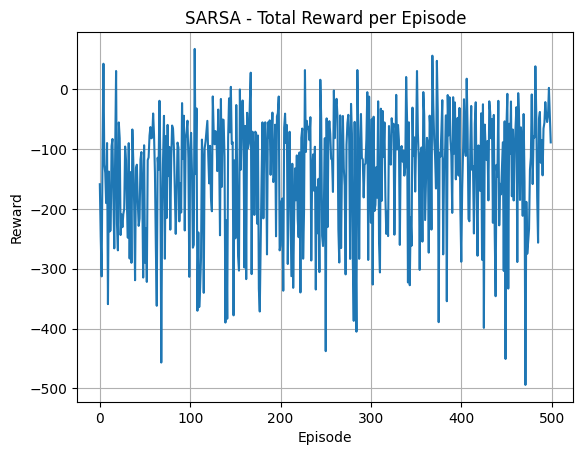

In [12]:
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.title("SARSA - Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

## 3.6. Evaluate Learned Policy

In [13]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

epsilon = 0.0  # Turn off exploration to follow the learned policy

state_continuous, _ = env.reset(seed=SEED + 999)
state = discretize_state(state_continuous)
frames = []

total_reward = 0
done = False

while not done:
    frame = env.render()
    frames.append(frame)

    action = np.argmax(Q[state])
    next_state_continuous, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = discretize_state(next_state_continuous)

    state = next_state
    total_reward += reward

env.close()
print("Test episode reward:", total_reward)

Test episode reward: -191.3931354648045


In [14]:
import imageio
import os

video_path = "/tmp/sarsa_lander.mp4"
imageio.mimsave(video_path, frames, fps=30)

from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=600 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

## 3.7. Hyperparameter Grid Search

In [15]:
# Define the search space

param_grid = {
    'alpha': [0.1, 0.05],
    'epsilon_decay': [0.99, 0.995],
    'gamma': [0.98, 0.99],
}

In [16]:
#generate all combinations

import itertools

param_combinations = list(itertools.product(
    param_grid['alpha'],
    param_grid['epsilon_decay'],
    param_grid['gamma']
))


In [24]:
import os

n_episodes = 300
max_steps = 1000

for i, (alpha, eps_decay, gamma) in enumerate(param_combinations):
    run_name = f"sarsa_run_{i+1:02d}_alpha{alpha}_epsdecay{eps_decay}_gamma{gamma}"
    print(f"\n Starting {run_name}")
    os.makedirs(run_name, exist_ok=True)

    Q = defaultdict(lambda: np.zeros(n_actions))
    epsilon = 1.0
    epsilon_min = 0.01
    rewards_per_episode = []

    for episode in range(n_episodes):
        state_cont, _ = env.reset(seed=SEED + episode)
        state = discretize_state(state_cont)
        action = select_action(state, Q, epsilon)

        total_reward = 0

        for step in range(max_steps):
            next_state_cont, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = discretize_state(next_state_cont)
            next_action = select_action(next_state, Q, epsilon)

            # SARSA update
            td_target = reward + gamma * Q[next_state][next_action] * (0 if done else 1)
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state
            action = next_action
            total_reward += reward

            if done:
                break

        epsilon = max(epsilon_min, epsilon * eps_decay)
        rewards_per_episode.append(total_reward)

    # Save rewards
    with open(os.path.join(run_name, "episode_rewards.txt"), "w") as f:
        for r in rewards_per_episode:
            f.write(f"{r}\n")

    # Save parameters
    with open(os.path.join(run_name, "params.txt"), "w") as f:
        f.write(f"alpha = {alpha}\n")
        f.write(f"epsilon_decay = {eps_decay}\n")
        f.write(f"gamma = {gamma}\n")

    print(f"Finished {run_name} | Avg last 50 rewards: {np.mean(rewards_per_episode[-50:]):.2f}")


 Starting sarsa_run_01_alpha0.1_epsdecay0.99_gamma0.98
Finished sarsa_run_01_alpha0.1_epsdecay0.99_gamma0.98 | Avg last 50 rewards: -130.93

 Starting sarsa_run_02_alpha0.1_epsdecay0.99_gamma0.99
Finished sarsa_run_02_alpha0.1_epsdecay0.99_gamma0.99 | Avg last 50 rewards: -105.79

 Starting sarsa_run_03_alpha0.1_epsdecay0.995_gamma0.98
Finished sarsa_run_03_alpha0.1_epsdecay0.995_gamma0.98 | Avg last 50 rewards: -145.52

 Starting sarsa_run_04_alpha0.1_epsdecay0.995_gamma0.99
Finished sarsa_run_04_alpha0.1_epsdecay0.995_gamma0.99 | Avg last 50 rewards: -114.19

 Starting sarsa_run_05_alpha0.05_epsdecay0.99_gamma0.98
Finished sarsa_run_05_alpha0.05_epsdecay0.99_gamma0.98 | Avg last 50 rewards: -145.26

 Starting sarsa_run_06_alpha0.05_epsdecay0.99_gamma0.99
Finished sarsa_run_06_alpha0.05_epsdecay0.99_gamma0.99 | Avg last 50 rewards: -126.33

 Starting sarsa_run_07_alpha0.05_epsdecay0.995_gamma0.98
Finished sarsa_run_07_alpha0.05_epsdecay0.995_gamma0.98 | Avg last 50 rewards: -165.58



## 3.8. Grid Visualization

In [25]:
# collect and Sort the results
import os
import numpy as np

sarsa_runs = []

for folder in sorted(os.listdir()):
    if folder.startswith("sarsa_run_") and os.path.isdir(folder):
        try:
            with open(os.path.join(folder, "params.txt")) as f:
                params = {
                    line.strip().split(" = ")[0]: line.strip().split(" = ")[1]
                    for line in f if " = " in line
                }

            rewards = np.loadtxt(os.path.join(folder, "episode_rewards.txt"))
            avg_last_50 = np.mean(rewards[-50:])

            sarsa_runs.append({
                "folder": folder,
                "alpha": float(params["alpha"]),
                "epsilon_decay": float(params["epsilon_decay"]),
                "gamma": float(params["gamma"]),
                "avg_reward": avg_last_50,
                "rewards": rewards
            })
        except Exception as e:
            print(f"Error in {folder}: {e}")

In [26]:
# Sort descending by average reward
sarsa_runs = sorted(sarsa_runs, key=lambda x: x["avg_reward"], reverse=True)

# Print top results
print("Top SARSA Configurations:")
for run in sarsa_runs[:3]:
    print(f"{run['folder']} | Avg reward: {run['avg_reward']:.2f}")


Top SARSA Configurations:
sarsa_run_02_alpha0.1_epsdecay0.99_gamma0.99 | Avg reward: -105.79
sarsa_run_04_alpha0.1_epsdecay0.995_gamma0.99 | Avg reward: -114.19
sarsa_run_06_alpha0.05_epsdecay0.99_gamma0.99 | Avg reward: -126.33


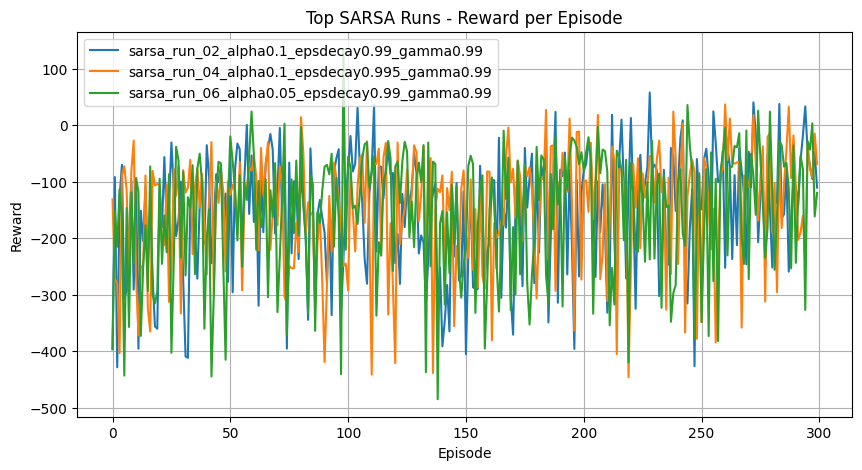

In [27]:
# Plot top N Curves

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for run in sarsa_runs[:3]:  # top 3
    plt.plot(run["rewards"], label=f"{run['folder']}")

plt.title("Top SARSA Runs - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

## 3.9. Retraining with Best Parameters

In [28]:
# Best parameters from grid search
alpha = 0.1
epsilon_decay = 0.99
gamma = 0.99

n_episodes = 500
max_steps = 1000
epsilon = 1.0
epsilon_min = 0.01

Q_final = defaultdict(lambda: np.zeros(n_actions))
rewards_final = []

for episode in range(n_episodes):
    state_cont, _ = env.reset(seed=SEED + episode + 1000)
    state = discretize_state(state_cont)
    action = select_action(state, Q_final, epsilon)

    total_reward = 0

    for step in range(max_steps):
        next_state_cont, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = discretize_state(next_state_cont)
        next_action = select_action(next_state, Q_final, epsilon)

        td_target = reward + gamma * Q_final[next_state][next_action] * (0 if done else 1)
        td_error = td_target - Q_final[state][action]
        Q_final[state][action] += alpha * td_error

        state = next_state
        action = next_action
        total_reward += reward

        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_final.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode} | Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f}")

Episode 0 | Reward: -108.89 | Epsilon: 0.990
Episode 50 | Reward: -76.59 | Epsilon: 0.599
Episode 100 | Reward: -380.85 | Epsilon: 0.362
Episode 150 | Reward: -115.73 | Epsilon: 0.219
Episode 200 | Reward: -296.18 | Epsilon: 0.133
Episode 250 | Reward: -8.49 | Epsilon: 0.080
Episode 300 | Reward: -60.18 | Epsilon: 0.049
Episode 350 | Reward: -78.24 | Epsilon: 0.029
Episode 400 | Reward: -131.27 | Epsilon: 0.018
Episode 450 | Reward: -319.70 | Epsilon: 0.011


In [29]:
# Save final rewards
with open("sarsa_best_rewards.txt", "w") as f:
    for r in rewards_final:
        f.write(f"{r}\n")

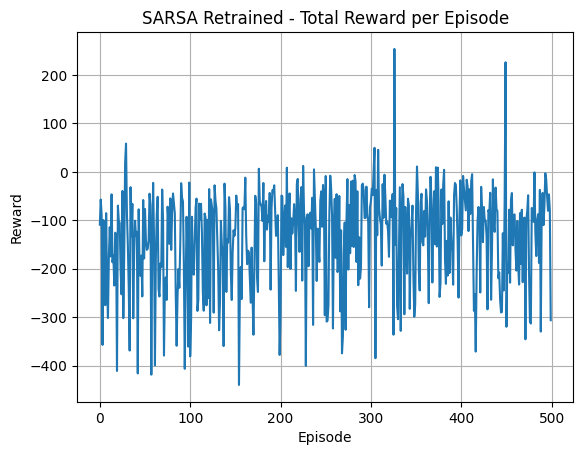

In [30]:
plt.plot(rewards_final)
plt.title("SARSA Retrained - Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

## 3.10. Final Evaluation plots

This section helps summarize SARSA performance after tuning and retraining. It also prepares for a clean comparison with DQN later.

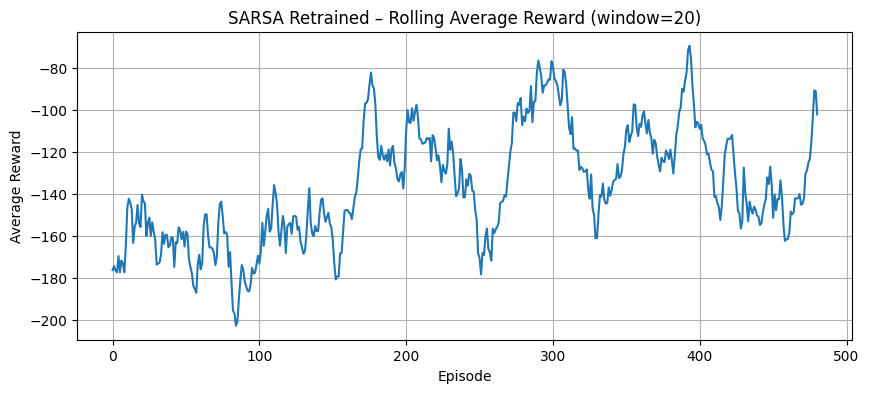

In [31]:
# This helps reveal trends behind the noise.

window = 20
rolling_avg = np.convolve(rewards_final, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 4))
plt.plot(rolling_avg)
plt.title(f"SARSA Retrained – Rolling Average Reward (window={window})")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

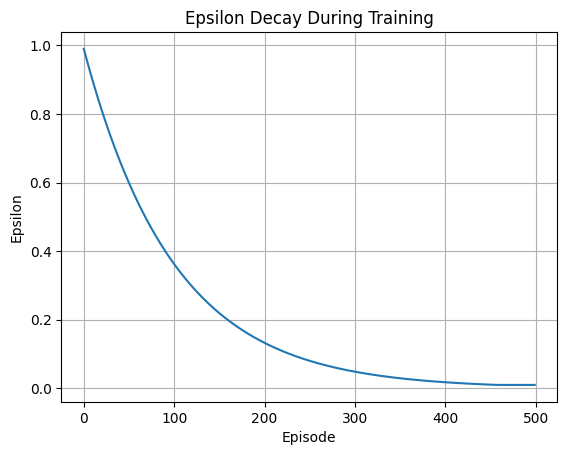

In [32]:
# Plot epsilon decay

epsilon_vals = []
epsilon = 1.0
for _ in range(n_episodes):
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon_vals.append(epsilon)

plt.plot(epsilon_vals)
plt.title("Epsilon Decay During Training")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.grid(True)
plt.show()


In [33]:
print("SARSA Final Stats:")
print(f"Average reward (last 50 episodes): {np.mean(rewards_final[-50:]):.2f}")
print(f"Max reward: {np.max(rewards_final):.2f}")
print(f"Min reward: {np.min(rewards_final):.2f}")
print(f"Percentage of episodes over -150: {np.mean(np.array(rewards_final) > -150)*100:.1f}%")


SARSA Final Stats:
Average reward (last 50 episodes): -134.55
Max reward: 253.97
Min reward: -439.85
Percentage of episodes over -150: 62.2%


## 3.11. Visualize the Lander

In [34]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")  # must use this mode!

In [35]:
frames = []
state_cont, _ = env.reset(seed=SEED + 2025)
state = discretize_state(state_cont)
total_reward = 0
done = False

while not done:
    frame = env.render()
    frames.append(frame)

    action = np.argmax(Q_final[state])
    next_state_cont, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = discretize_state(next_state_cont)

    state = next_state
    total_reward += reward

env.close()
print(f"Total reward in test episode: {total_reward:.2f}")


Total reward in test episode: -79.05


In [36]:
import imageio
from IPython.display import HTML
from base64 import b64encode

video_path = "/tmp/sarsa_final_lander.mp4"
imageio.mimsave(video_path, frames, fps=30)

# Display
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")